In [169]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 300
PATCHSIZE = 5
borderXorigin = 190
borderYorigin = 190
borderXend = 210
borderYend = 210

In [170]:
def read(image_uri) : #Put URI of image #Out : Matrix of the image
    return iio.imread(image_uri)

def view(image) : #you can put a matrix or a URI and it plots the image/matix

    if isinstance(image, str) :
          image = read(image)

    plt.imshow(image , cmap = 'gray')
    plt.show()
    
def save(image,filename) : #convert Matrix to an image
    iio.imwrite(filename, image)
    

def maskeffect(image,mask,f) : #You can put a matrix or a URI #apply effect to a zone of the image
    """
    Apply f on all the pixels 1 of the mask on the image
    """
    
    if isinstance(image, str) :
        image = read(image)
    
    if not mask.shape[:2] == image.shape[:2]:
        return print("⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️The mask doesn't fit the image ⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️" )
    
    out = image.copy()
    
    for x in range(mask.shape[0]) :
        for y in range(mask.shape[1]) :
            if mask[x,y] == 0 :
                out[x,y] = f(x,y)
    return out

def generate_mask(image) : #Generate a mask of the size of the image
    
    if isinstance(image, str) :
        image = read(image)
    
    out = np.ones(image.shape)
    return out

def zone_mask(mask,startX = borderXorigin, startY = borderYorigin, endX = borderXend,endY = borderYend) : #Select the zone of the image to apply effects
    
    for x in range(startX,endX + 1):
        for y in range(startY,endY + 1):
            mask[x,y] = 0
    

Example of mask effect functions

In [171]:
def nullify(x,y):
    return 0

def grisify(x,y):
    return 120

def invert(image):
    def inversion(x,y): 
        return 255- image[x,y]
    return inversion

def copy(image,startX,startY,offsetX,offsetY):
    def copy(x,y):
        return image[startX + (x-offsetX), startY + (y-offsetY)]
    return copy


[[ 10.  10.  10. ... 139. 139. 139.]
 [ 10.  10.  10. ... 139. 139. 139.]
 [ 10.  10.  10. ... 139. 139. 139.]
 ...
 [ 10.  10.  10. ... 139. 139. 139.]
 [ 10.  10.  10. ... 139. 139. 139.]
 [ 10.  10.  10. ... 139. 139. 139.]]


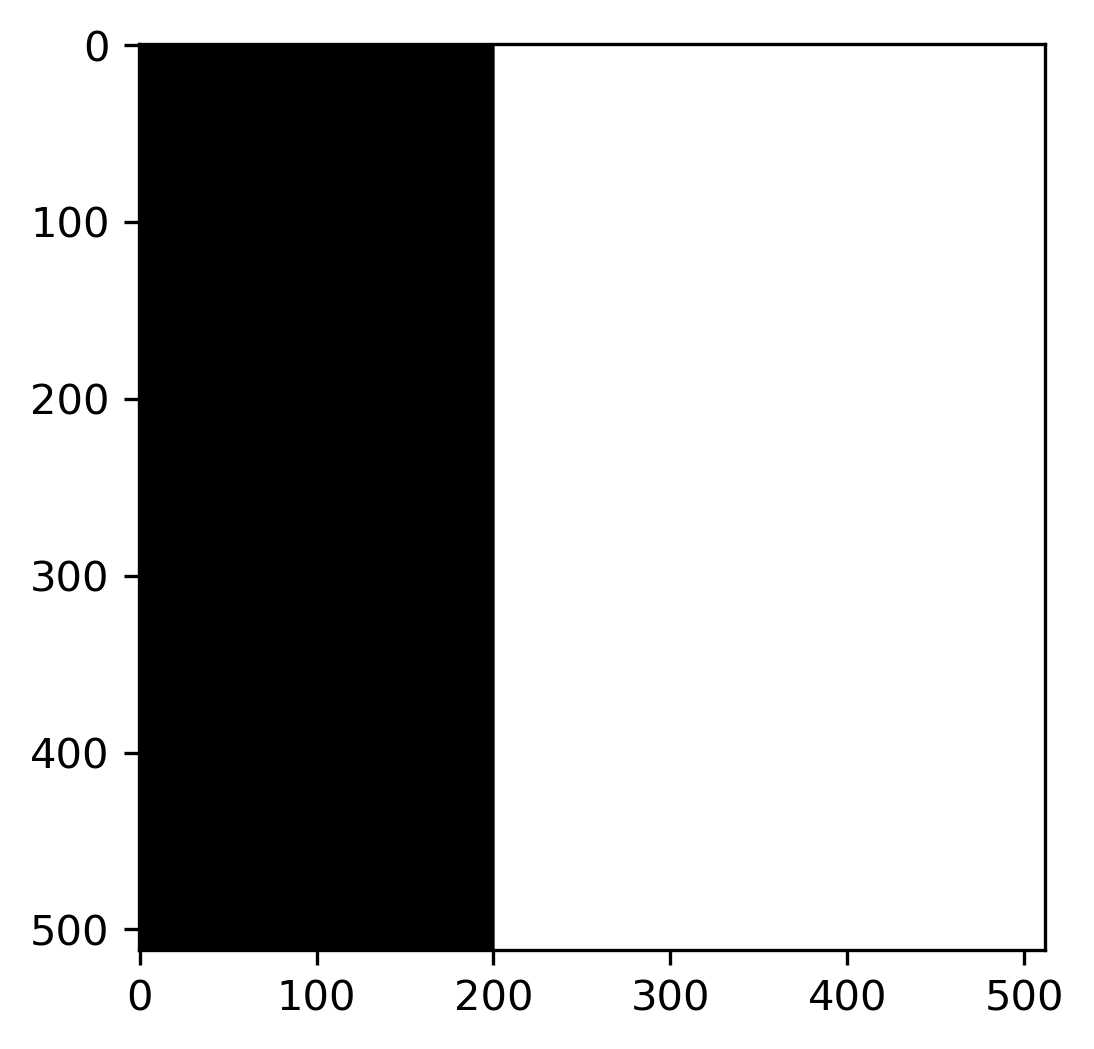

In [172]:

lena = read("lena.tif")
lena = generate_mask(lena) +128
zone_mask(lena,0,0,lena.shape[0]-1,200)

lena = lena +10

print(lena)
view(lena)

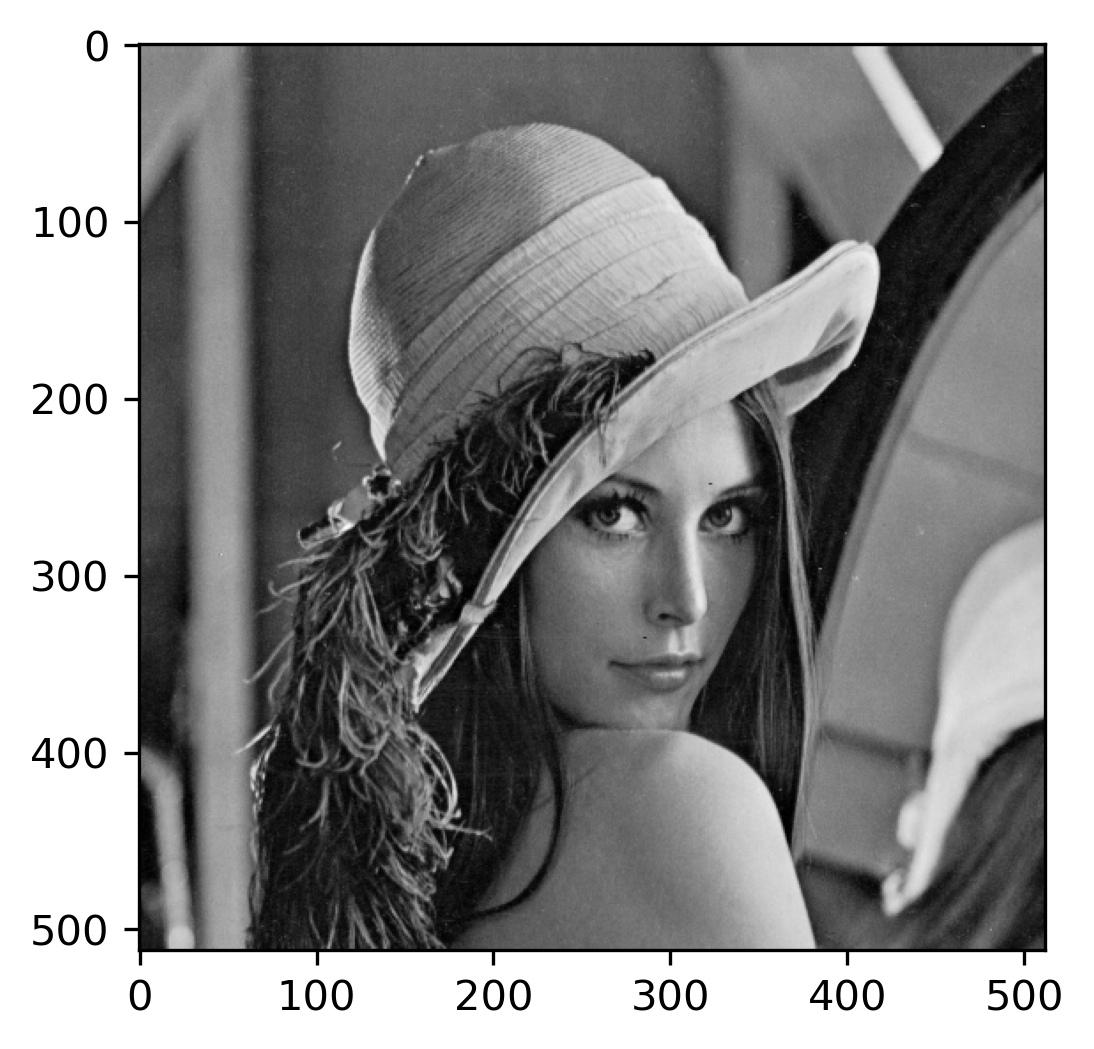

In [173]:
view("lena.tif")

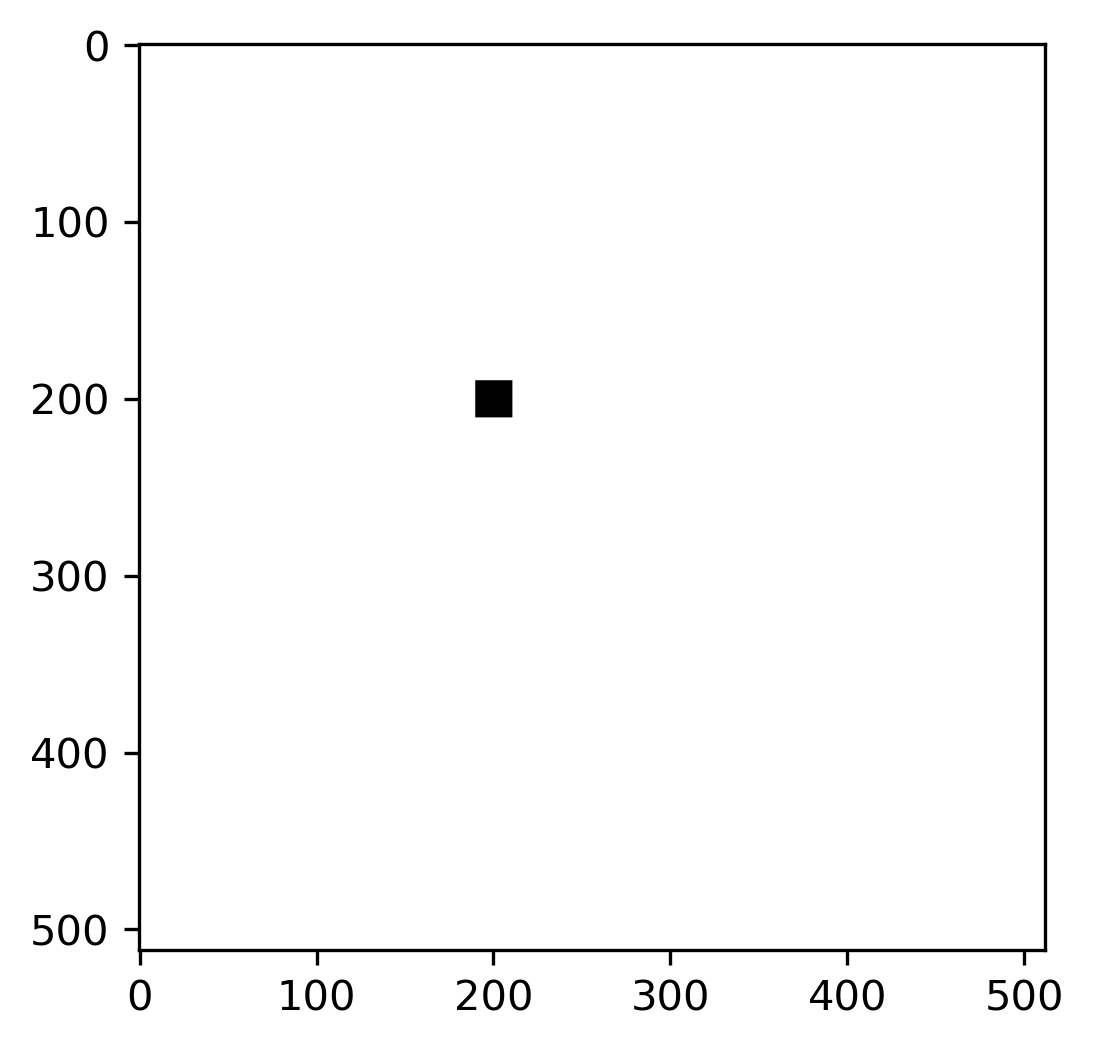

In [174]:
mask = generate_mask(lena)

zone_mask(mask,borderXorigin,borderYorigin,borderXend,borderYend)

save(mask,"mask.tif")

view(mask)

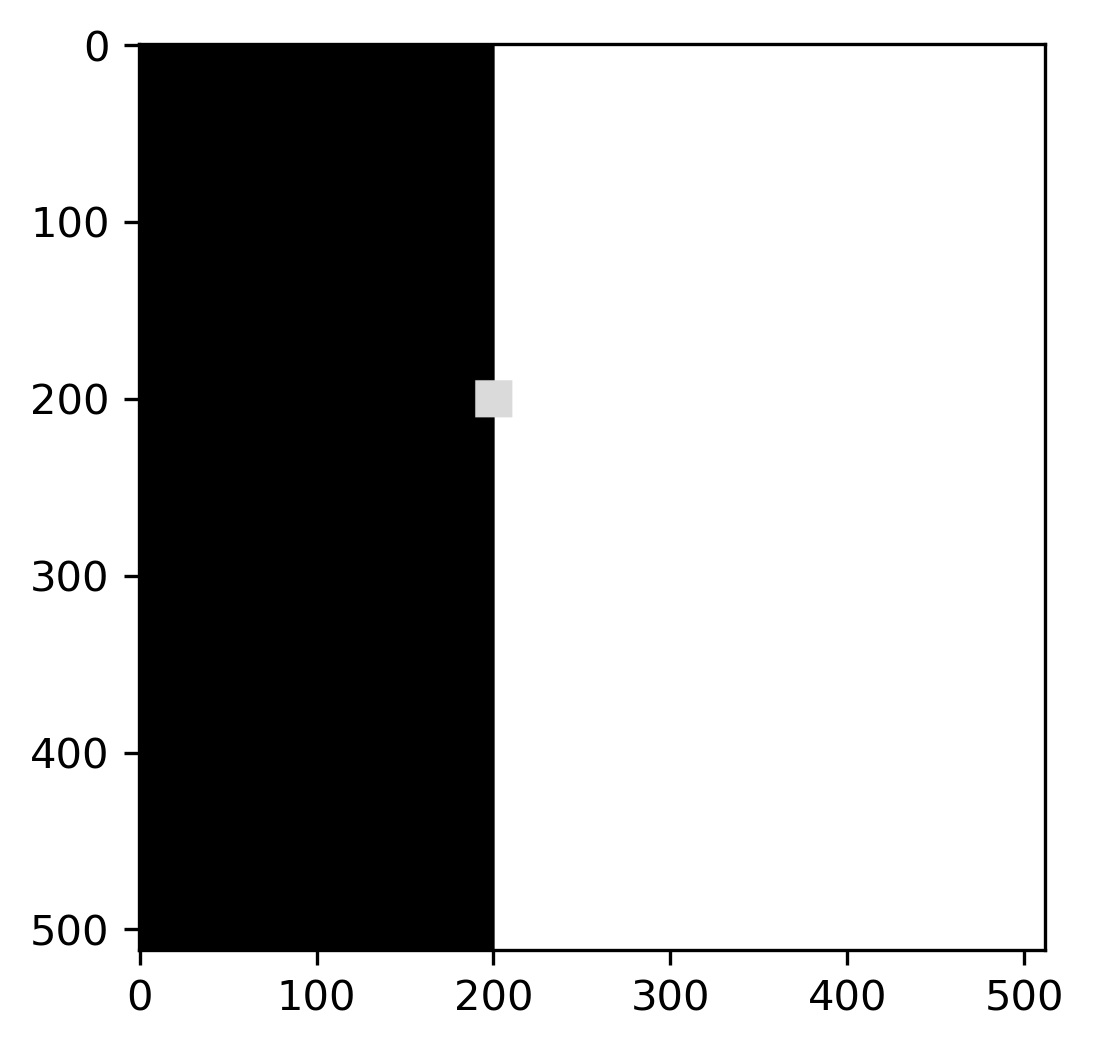

In [175]:
lena_effect = maskeffect(lena,mask,grisify)
view(lena_effect)

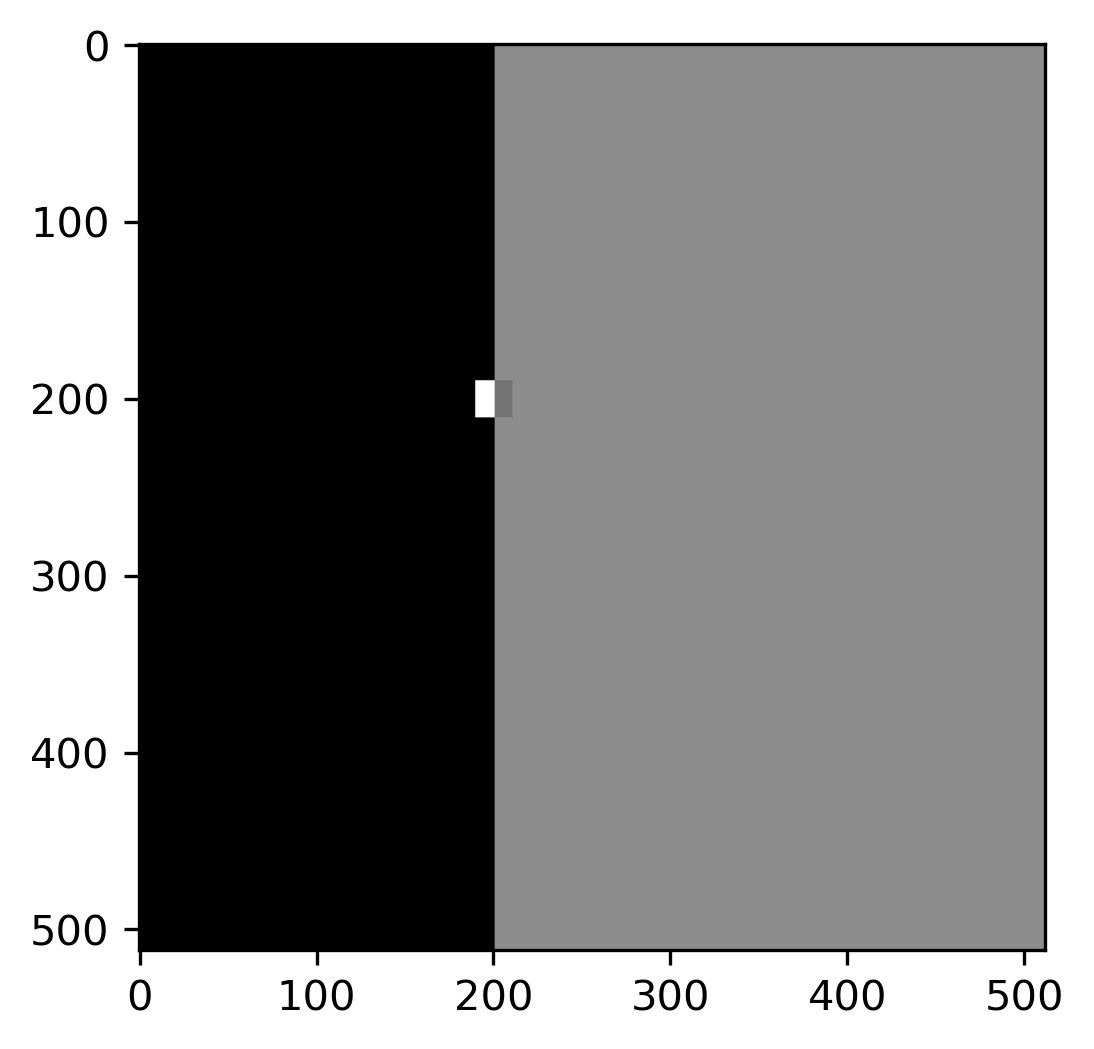

In [176]:
lena_invert = maskeffect(lena, mask, invert(lena))
view(lena_invert)

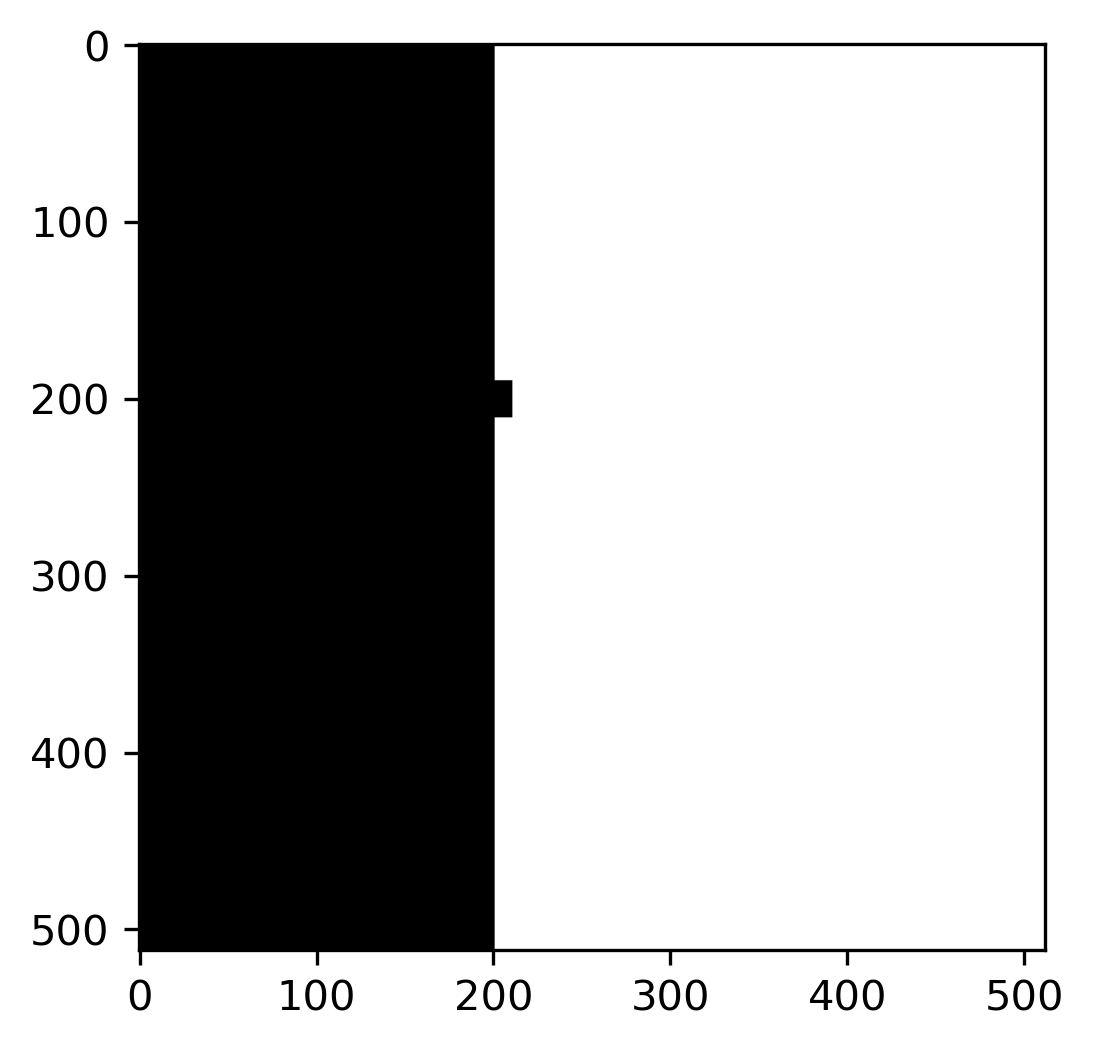

In [177]:
lena_copy = maskeffect(lena,mask, copy(lena,0,0,100,100))
view(lena_copy)

In [178]:
def get_patch(image,position,patch_size= PATCHSIZE):
    r= patch_size // 2 
    clip = image[position[0]-r:position[0]+r+1, position[1]-r:position[1]+r+1]
    return clip    

def c_matrix(mask):
    n,m= mask.shape
    c=np.zeros(mask.shape,dtype=np.float128)
    for k in range(n):
        for l in range(m):
            patch = get_patch(mask,(k,l))
            c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])
    return c

In [179]:
save((c_matrix(mask)),"c.tif")


/tmp/ipykernel_57162/1091943012.py:12: RuntimeWarning: invalid value encountered in double_scalars
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


In [180]:
def init_border(startX = borderXorigin, startY = borderYorigin, endX = borderXend,endY = borderYend):
    border = []
    for y in range(startY-1,endY + 2):
        border.append((startX-1,y))
        border.append((endX+1,y))

    for x in range(startX ,endX+1):
        border.append((x,startY-1))
        border.append((x,endY+1))
    
    return border

def update_border(mask,border,position,patch_size = PATCHSIZE) :
    r = patch_size // 2
    x,y = position
    for i in range(-r,r+1) :
        if mask[x-r-1,y+i] == 0 : border.append((x-r-1,y+i)) #UP
        if mask[x+r+1,y+i] == 0 : border.append((x+r+1,y+i)) #DOWN
        if mask[x+i,y-r-1] == 0 : border.append((x+i,y-r-1)) #LEFT
        if mask[x+i,y+r+1] == 0 : border.append((x+i,y+r+1)) #RIGHT

    for i in range(-r,r+1) :
        for j in range(-r,r+1):
            try :
                border.remove((x+i,y+j))
            except : 
                pass

def draw_border(mask,border):
    border_mask = np.zeros(mask.shape)
    for (x,y) in border :
        border_mask[x,y] = 1

    return border_mask



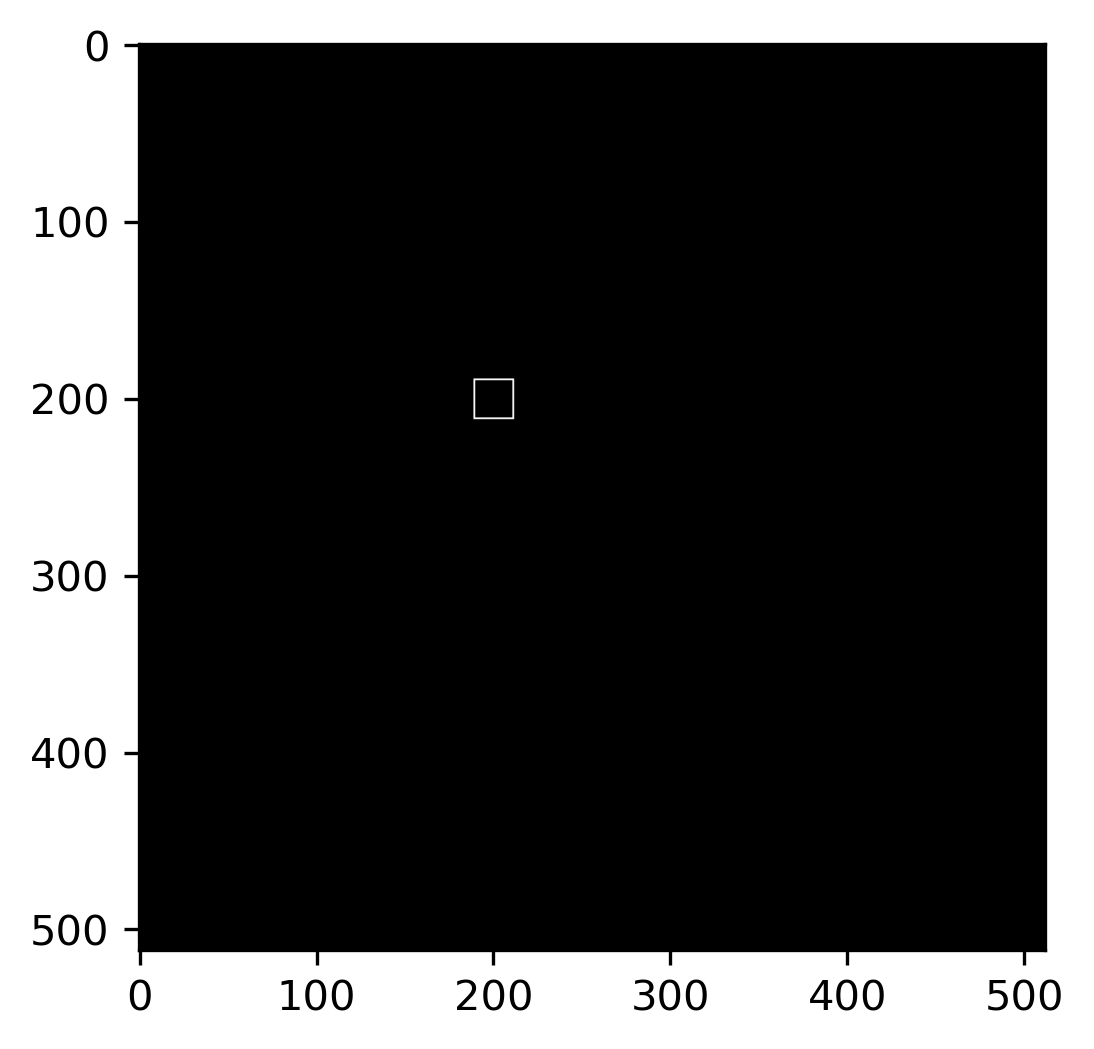

In [181]:
mask = generate_mask(lena)

zone_mask(mask)

border = init_border()

view(draw_border(mask,border))



In [182]:
position = (100, 150)

x,y = position

update_border(mask,border,position,patch_size = PATCHSIZE)

r = PATCHSIZE//2
for i in range(-r,r+1) :
    for j in range(-r,r+1):
        mask[x+i,y+j]= 1





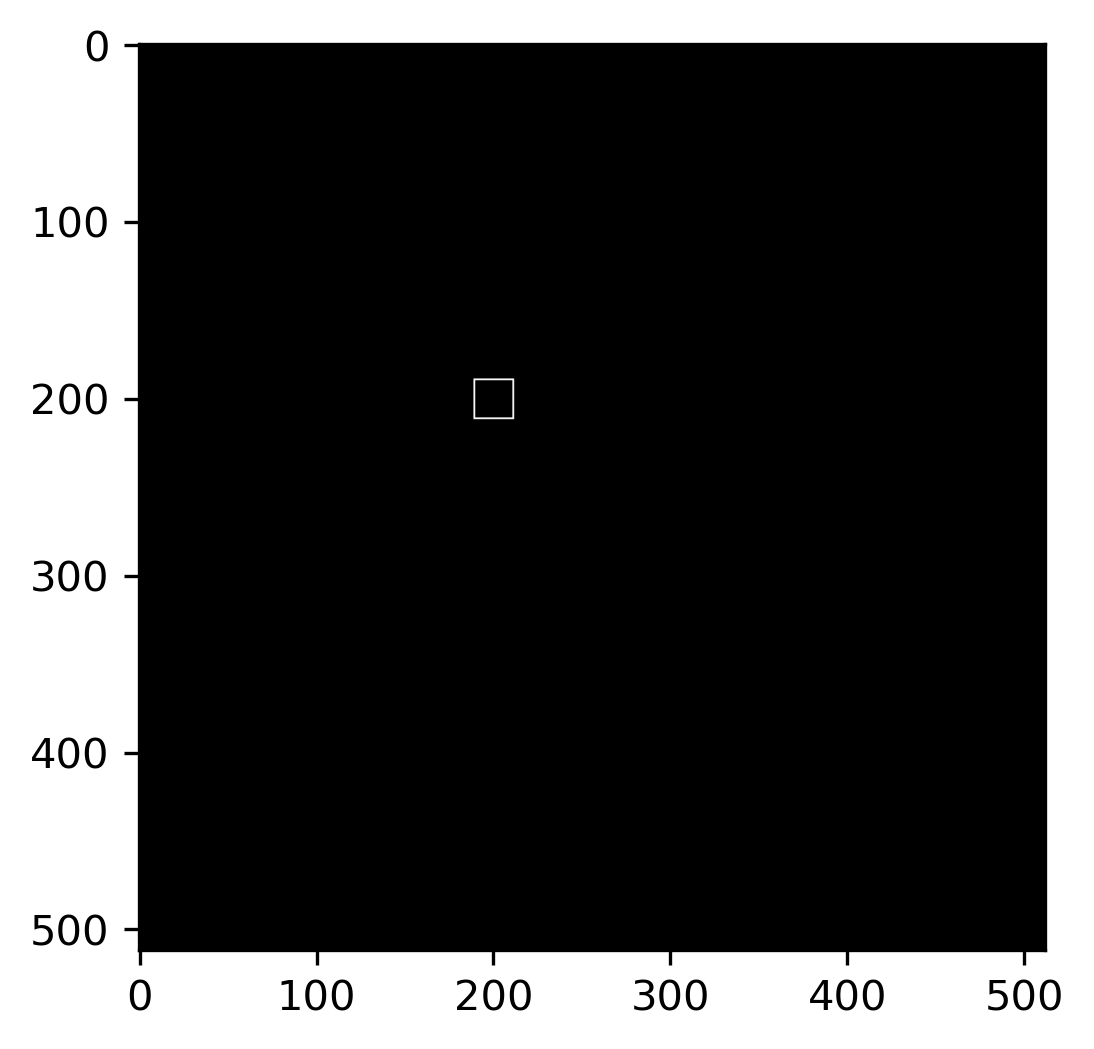

In [183]:
view(draw_border(mask,border))
save(draw_border(mask,border),"border.tif")

In [184]:
def sobelGradX(ima):

    nl,nc=ima.shape
    gradx=np.zeros((nl,nc))

    for i in range(1,nl-1):
        for j in range(1,nc-1):
            gradx[i,j]=ima[i-1,j+1]+2*ima[i,j+1]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i,j-1]-ima[i+1,j-1];
            
    return gradx
              
def sobelGradY(ima):

    nl,nc=ima.shape
    grady=np.zeros((nl,nc))

    for i in range(1,nl-1):
        for j in range(1,nc-1):
            grady[i,j]=ima[i+1,j-1]+2*ima[i+1,j]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i-1,j]-ima[i-1,j+1];
        
    return grady

def maskify_image(image,mask) : 
    masked_image = np.copy(image)
    for x in range(mask.shape[0]) :
        for y in range(mask.shape[1]) :
            if mask[x,y] == 0 : masked_image[x,y] = 65
    return masked_image


In [185]:
def get_grad_color(patch) : # DeltaI de p
    
    gradX = sobelGradX(patch)
    gradY = sobelGradY(patch)

    centerX, centerY = patch.shape[0]//2 ,patch.shape[1]//2
    
    x,y = centerX, centerY 

    if patch[centerX + 1, centerY] == 0 : x = centerX -1
    if patch[centerX - 1, centerY] == 0 : x = centerX +1

    if patch[centerX, centerY + 1] == 0 : y = centerY -1
    if patch[centerX, centerY-1] == 0 : y = centerY +1

    return gradX[x,y],gradY[x,y]
    


In [186]:
def get_grad_border(mask,position) : #n(p)
    
    patch = get_patch(mask,position)
    
    gradX = sobelGradX(patch)
    gradY = sobelGradY(patch)

    centerX, centerY = patch.shape[0]//2 ,patch.shape[1]//2

    return gradY[centerX, centerY],gradX[centerX, centerY]

In [187]:
n=8
(x,y) = 200 ,200
print(border[n])
masked = maskify_image(lena,mask)
print(get_patch(masked,(x,y)))
print(get_patch(mask,(x,y)))

print(get_grad_color(get_patch(masked,(x,y))))
print(get_grad_border(mask,(x,y)))

(189, 193)
[[65. 65. 65. 65. 65.]
 [65. 65. 65. 65. 65.]
 [65. 65. 65. 65. 65.]
 [65. 65. 65. 65. 65.]
 [65. 65. 65. 65. 65.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
(0.0, 0.0)
(0.0, 0.0)


In [188]:
def diff_patch(patch1,patch2):
    matrix = patch1 -patch2
    return np.sum((matrix**2))

def checkMask(mask,position) : 
    return mask[position] == 1


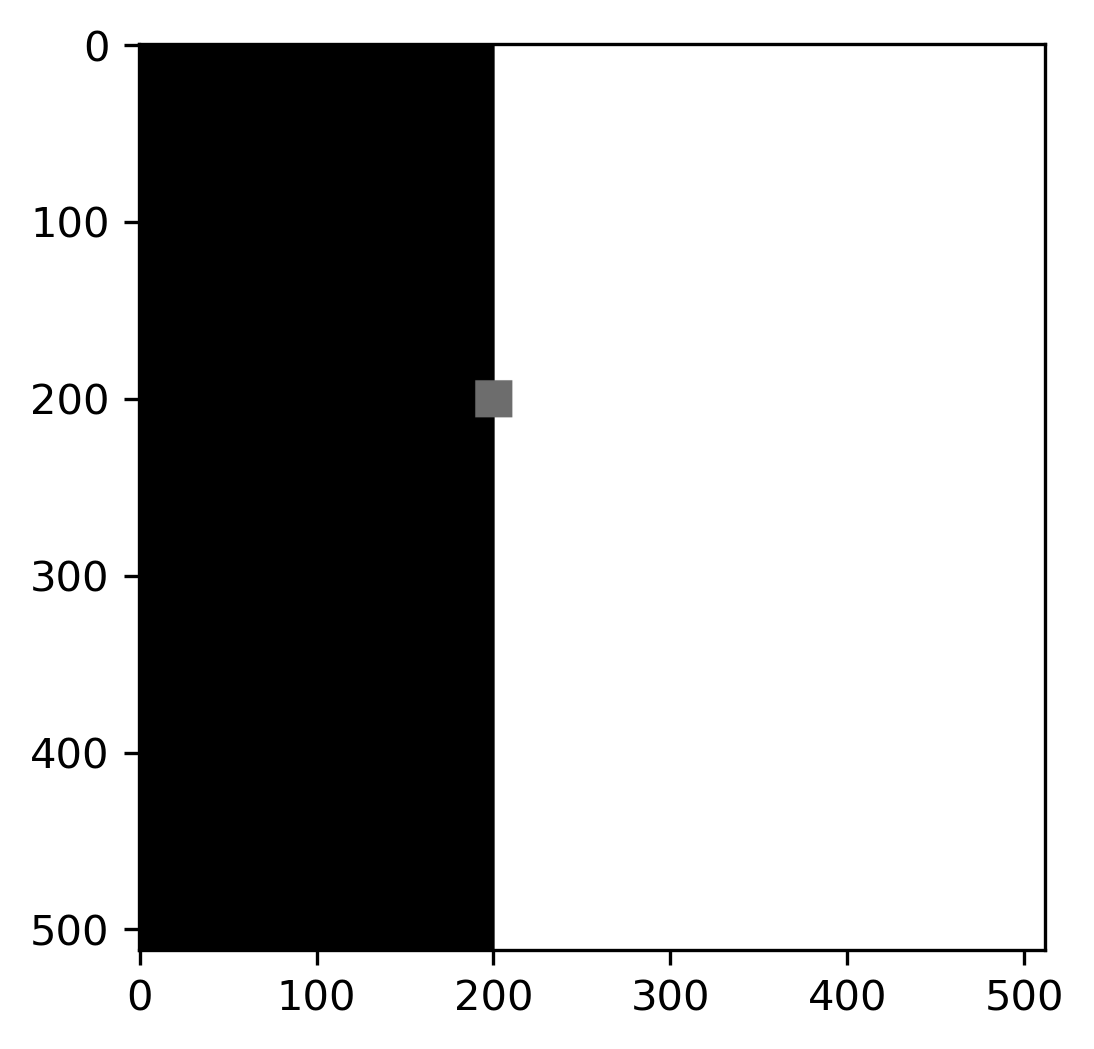

/tmp/ipykernel_57162/1091943012.py:12: RuntimeWarning: invalid value encountered in double_scalars
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


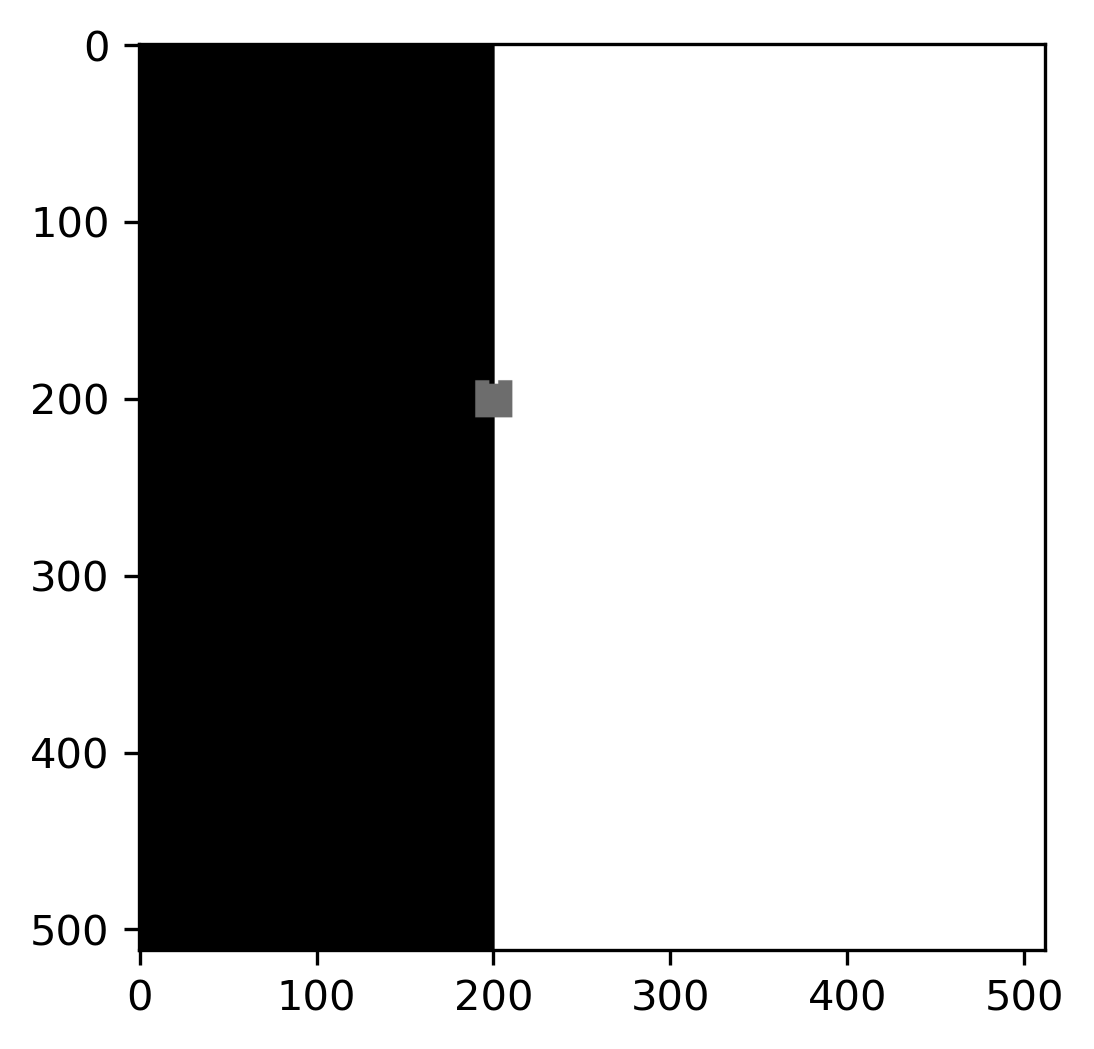

92
96
98
100
95
95
97
99
99
100


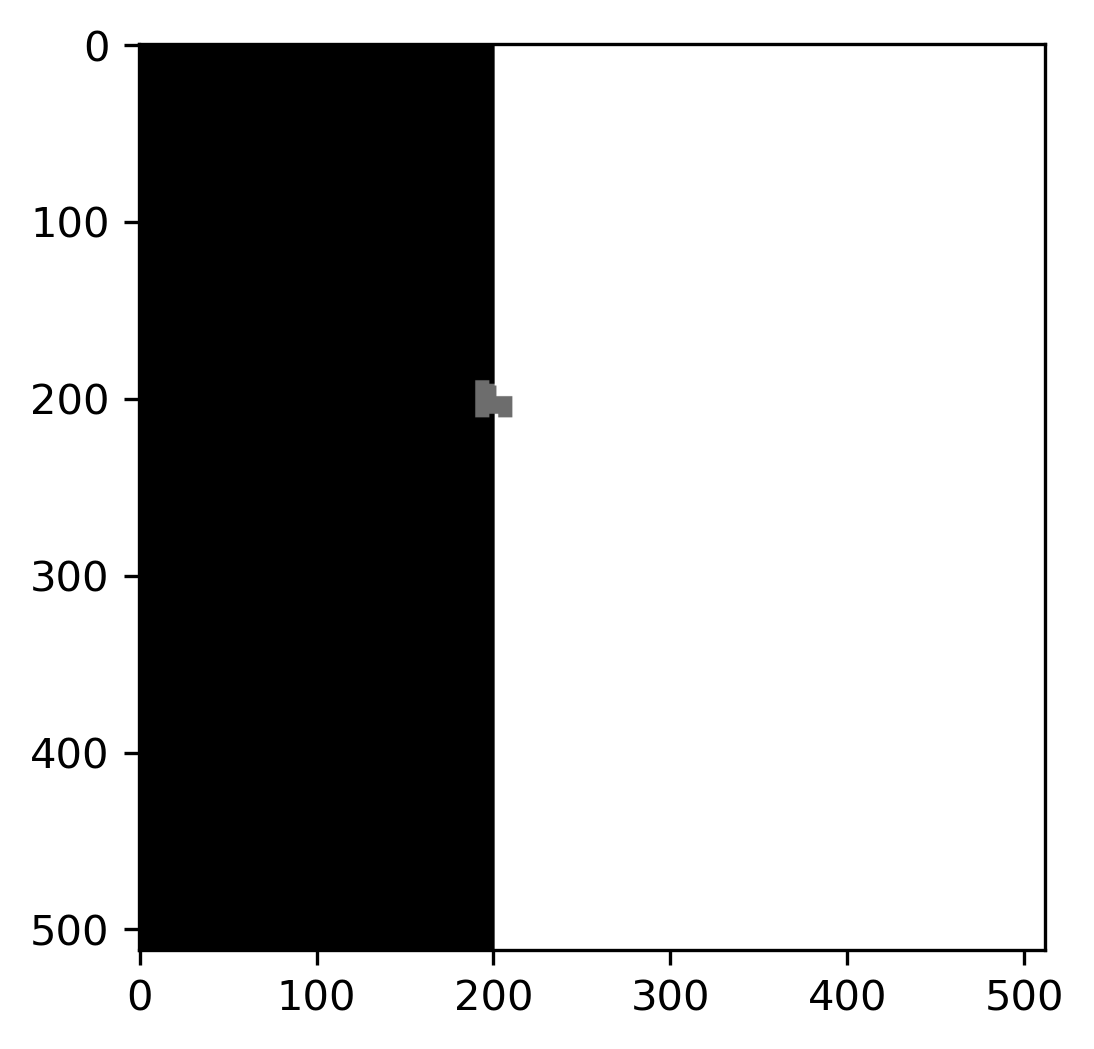

103
103
104
107
107
108
111
111
112
115


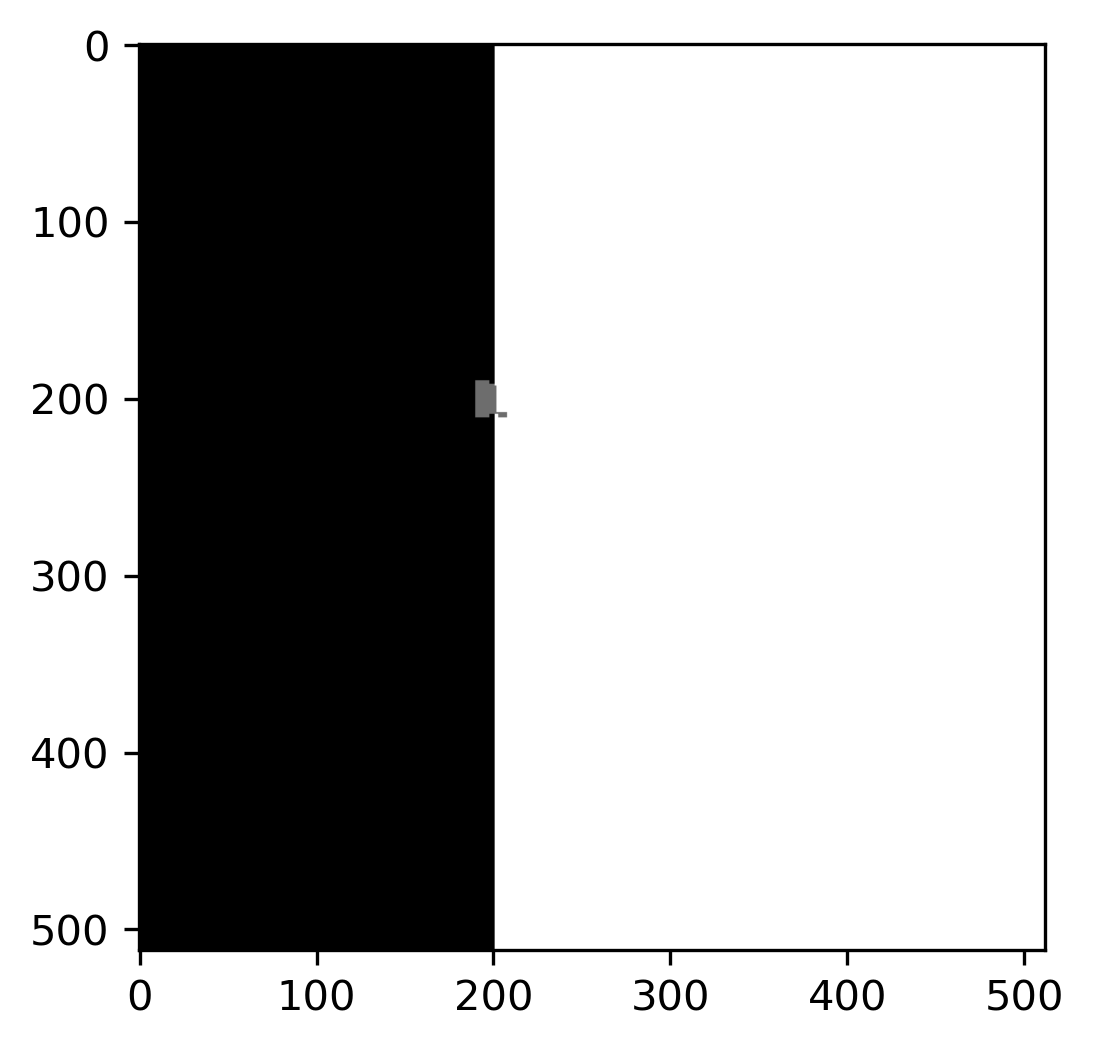

112
108
102
102
103
105
107
109
110
111


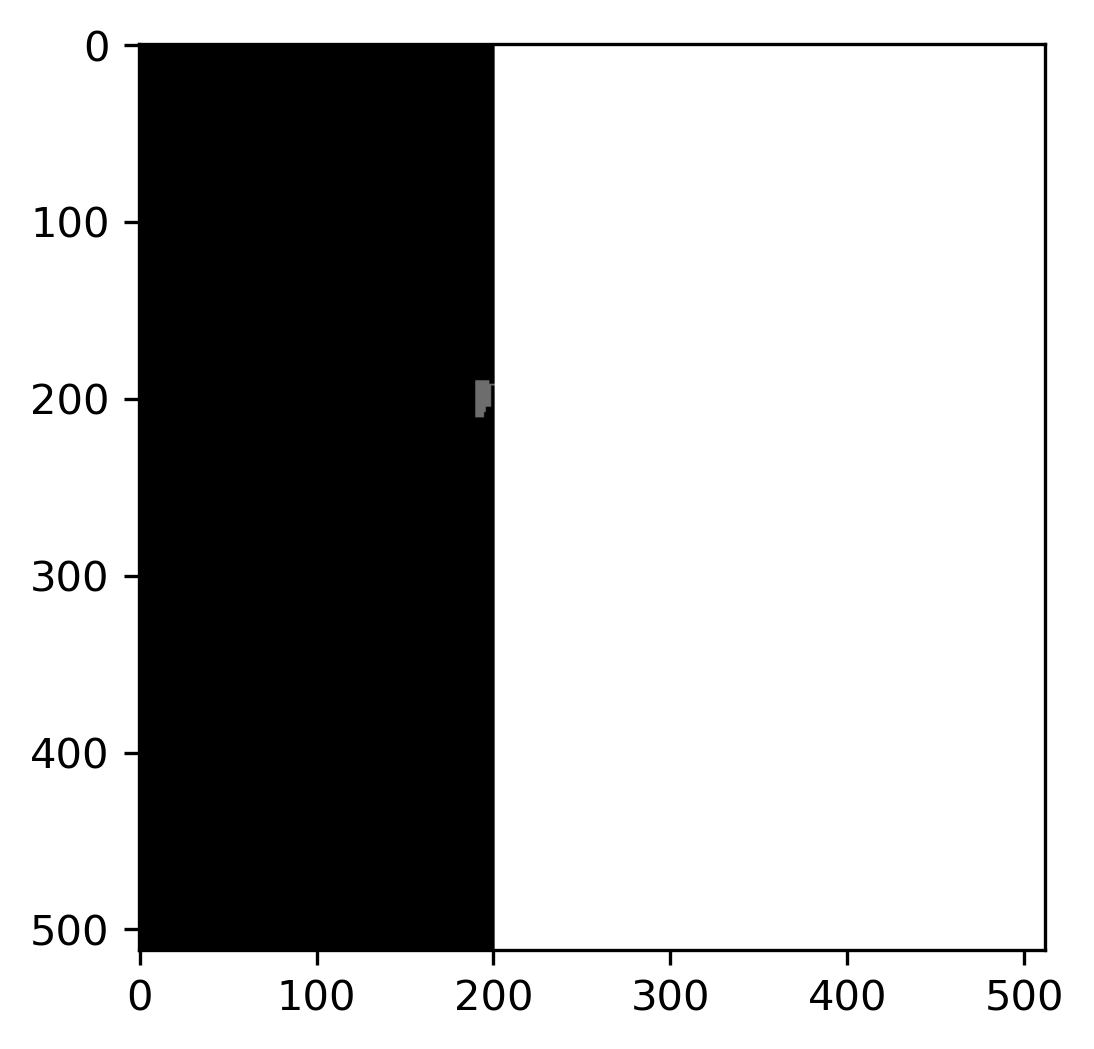

111
112
113
114
117
118
113
114
115
116


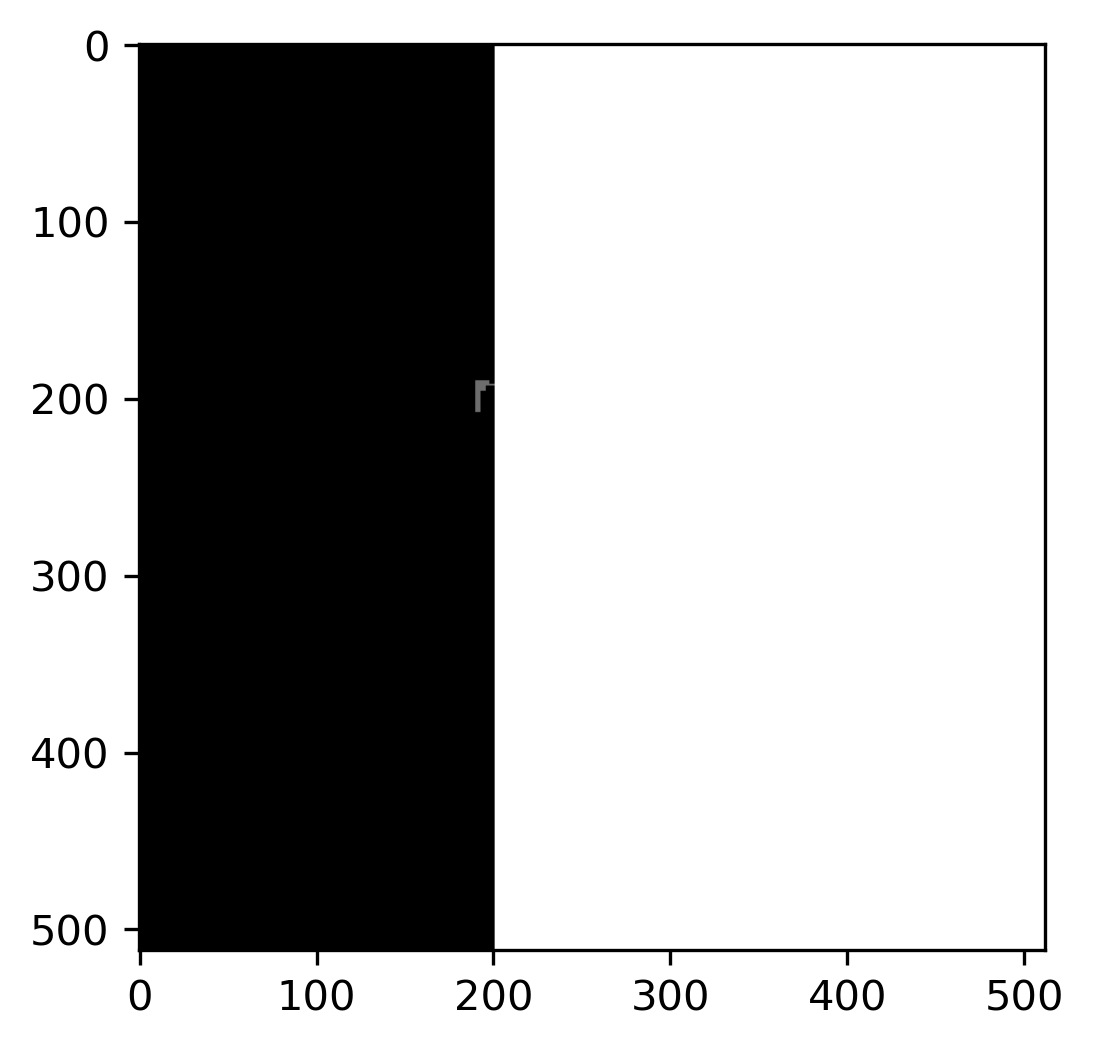

117
120
117
113
109
105
103
98
96
89


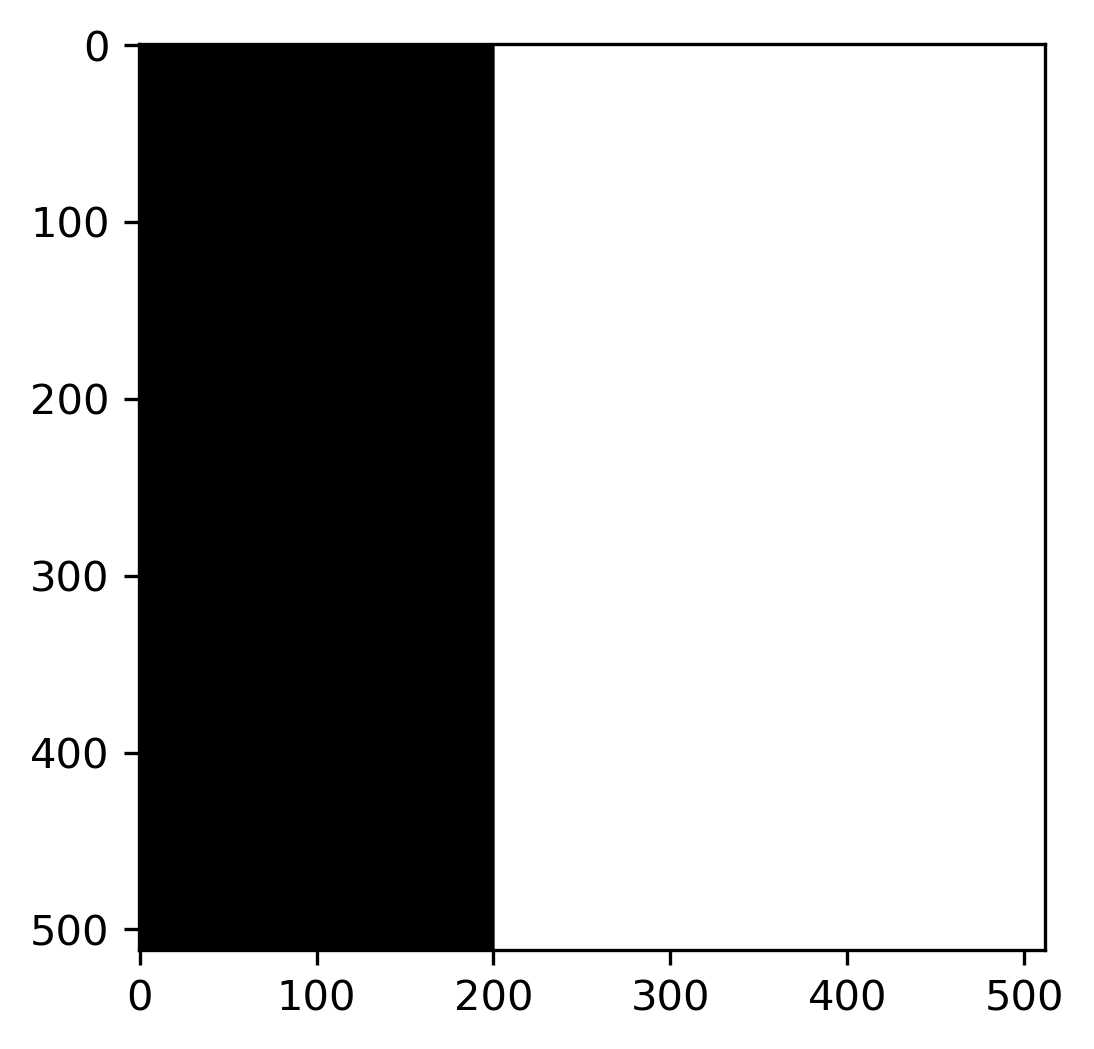

84
81
78
75
72
69
66
63
60
57


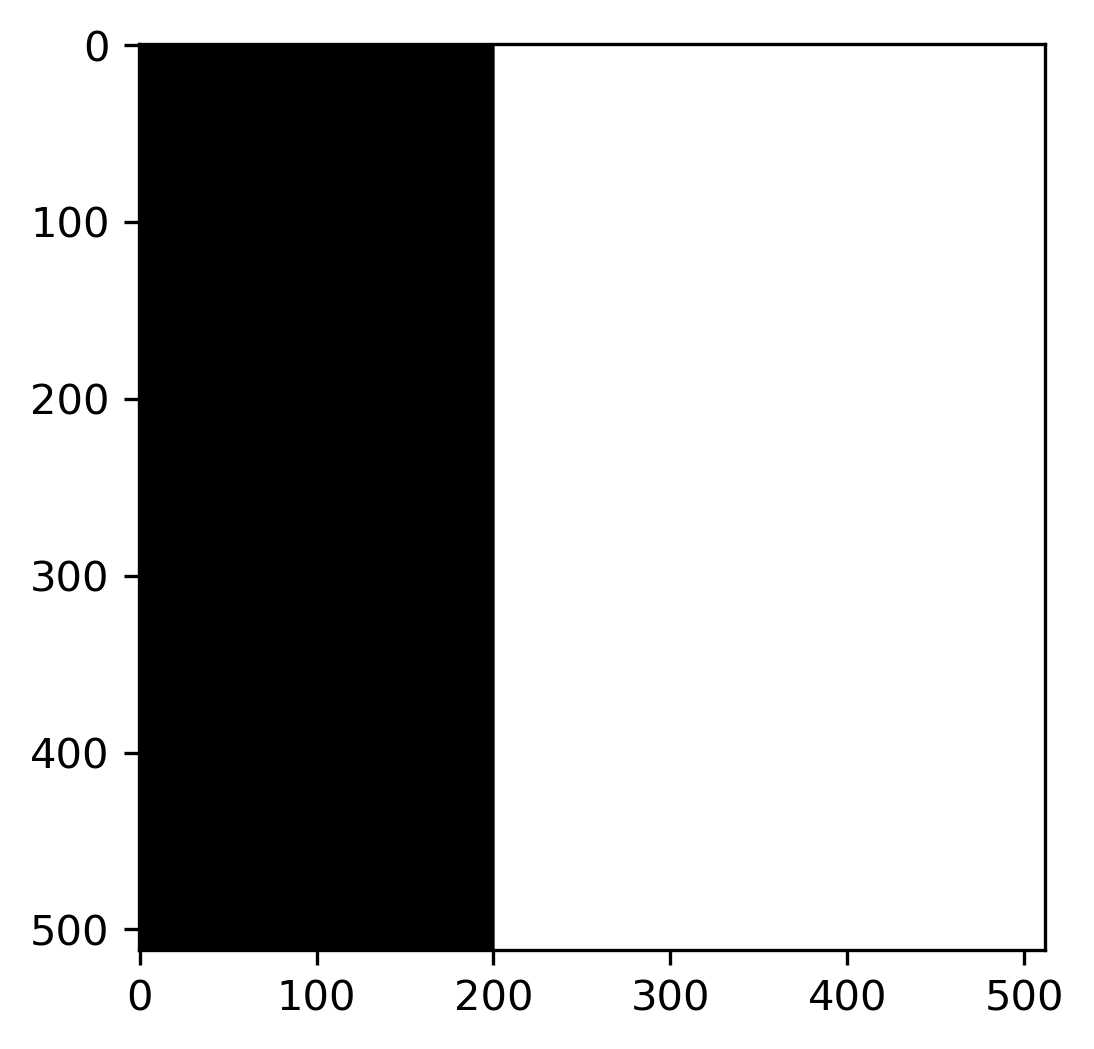

54
53
50
49
48
47
46
45
44
43


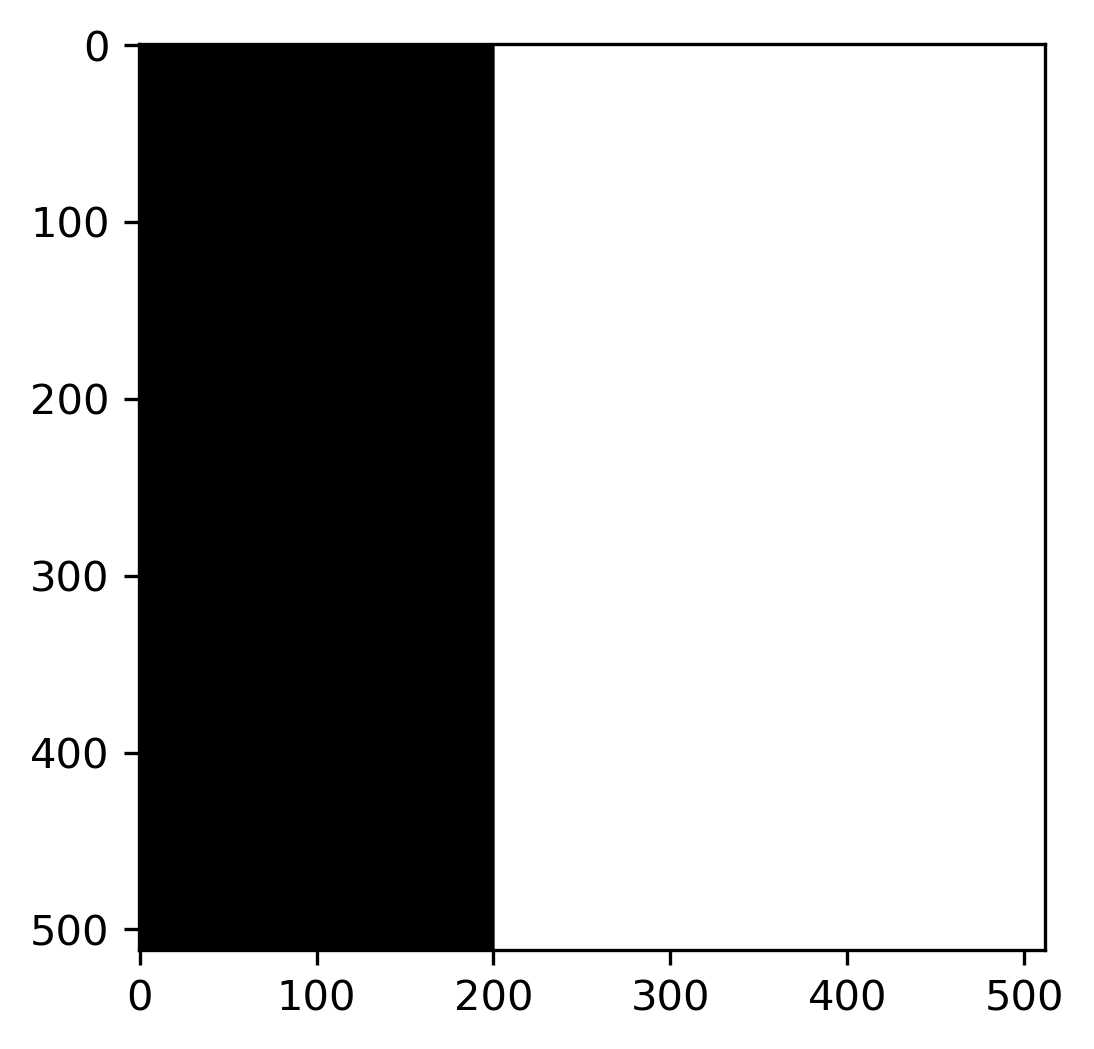

42
41
40
39
37
36
35
34
33
30


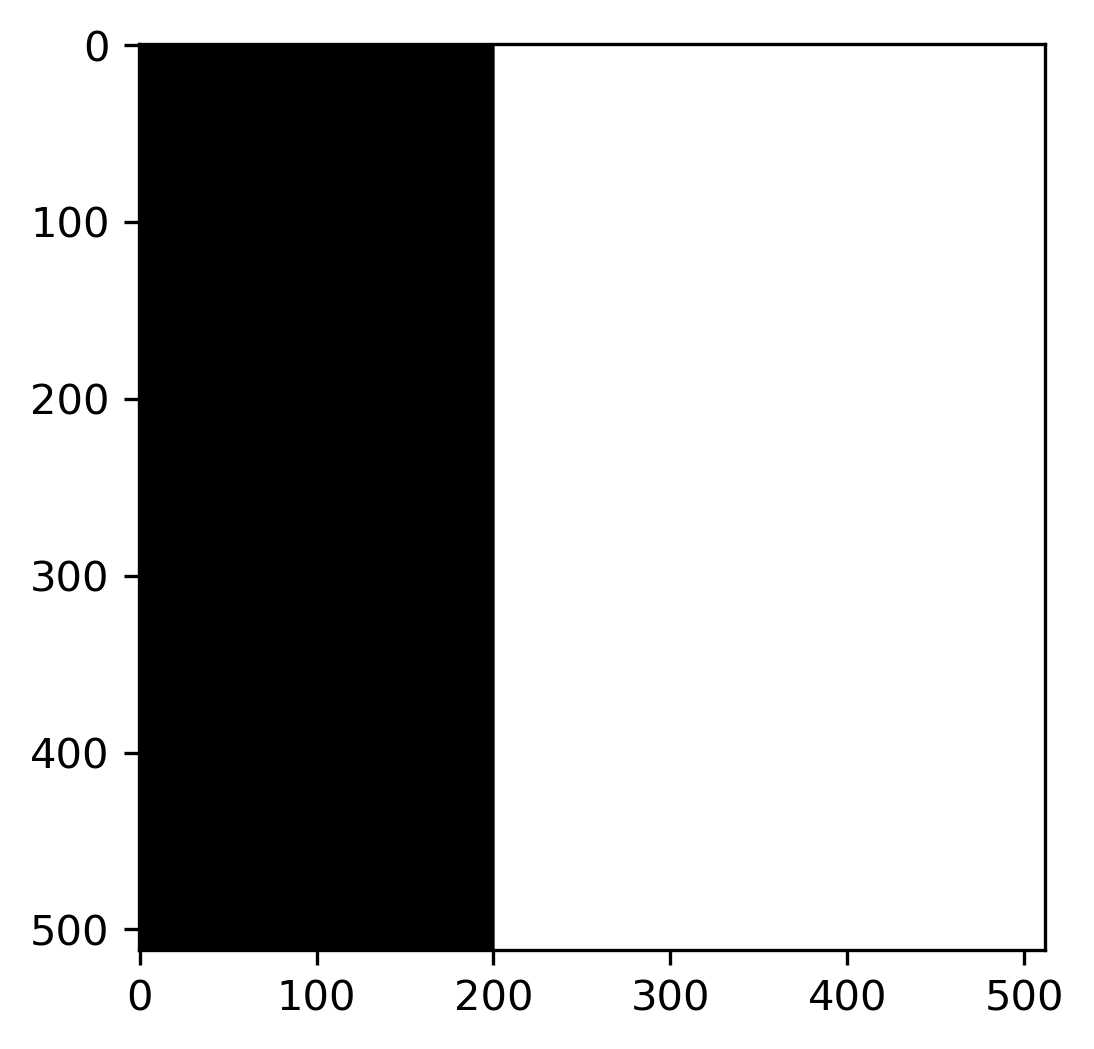

29
28
27
26
24
23
22
21
20
19


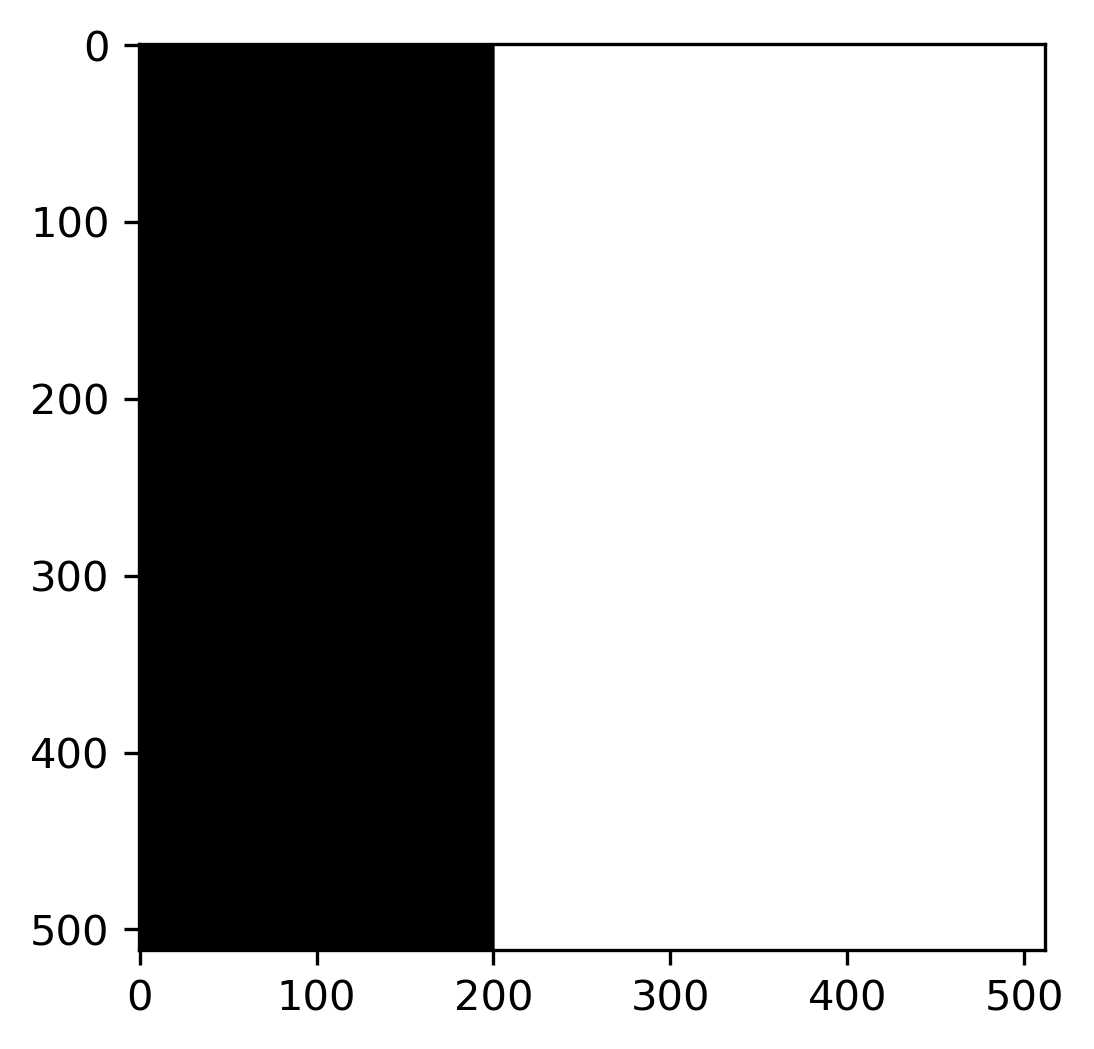

18
16
15
14
13
12
11
10
9
7


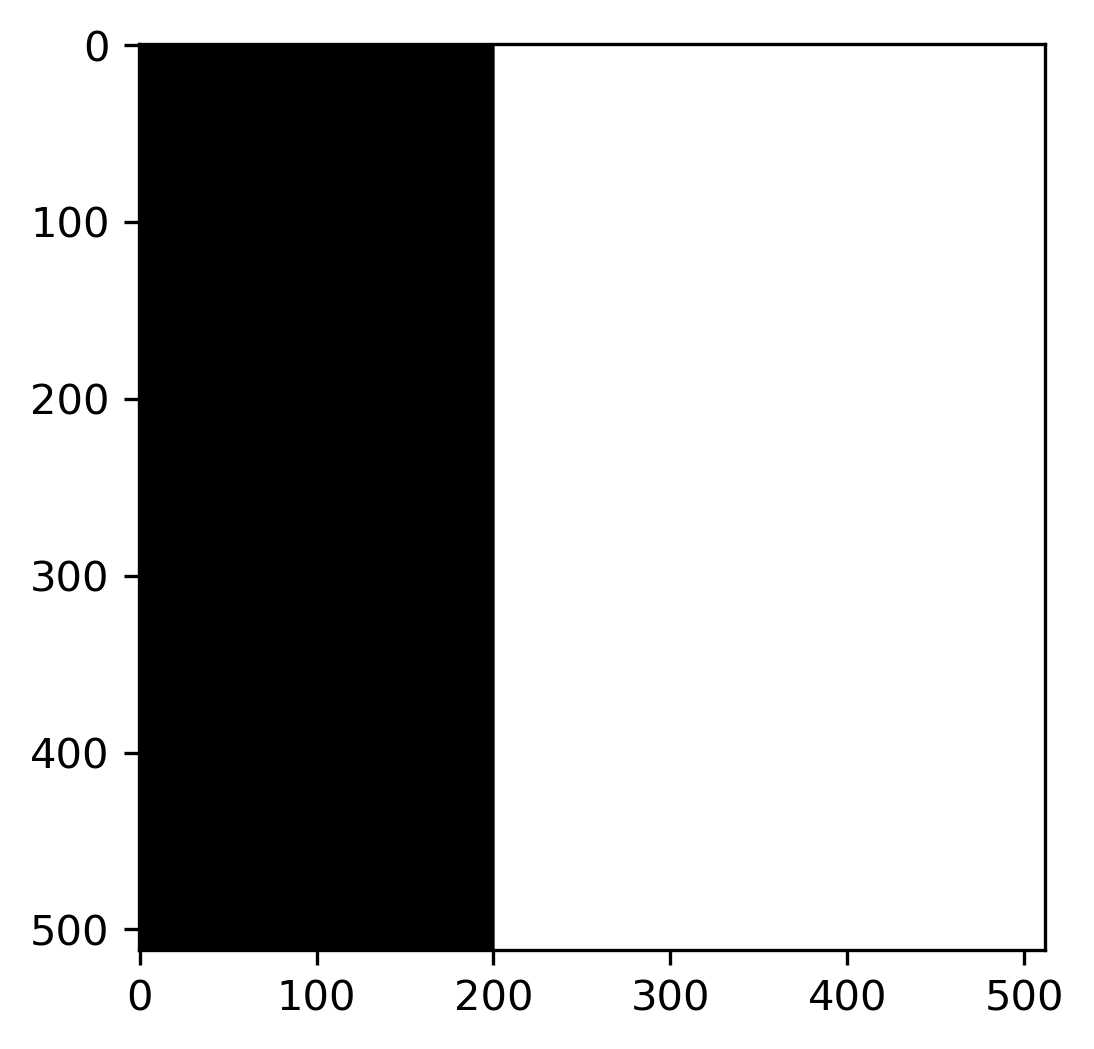

6
5
4
3
2
1
0


In [189]:
import time as time
image = lena

mask = generate_mask(image)
zone_mask(mask)
border = init_border()

masked = maskify_image(lena,mask)

view(masked)

r= PATCHSIZE//2
K=0

while len(border) != 0 :
    x,y = border[0]
    C = c_matrix(mask)
    P = abs(C[x,y])*abs(np.sum(np.multiply(get_grad_border(mask,(x,y)),get_grad_color(get_patch(masked,(x,y))))))
    
    chosenX,chosenY = x,y
    for x,y in border :
        tempP = abs(C[x,y])*abs(np.sum(np.multiply(get_grad_border(mask,(x,y)),get_grad_color(get_patch(masked,(x,y))))))
        if tempP > P :
            P = tempP
            chosenX,chosenY = x,y

    refPatch = get_patch(masked,(chosenX,chosenY))
    #view(refPatch)
    replacementPatch = get_patch(masked,(r,r))
    X,Y =0,0
    d = diff_patch(replacementPatch,refPatch)
    
    for x in range (r, masked.shape[0]-r):
            for y in range (r,masked.shape[1]-r) :

                potential = True
                for i in range(x-r,x+r+1):
                    for j in range(y-r,y+r+1):
                        if checkMask(mask,(i,j)) == 0  : potential = False

                if potential :
                    testPatch = get_patch(masked,(x,y))
                    dtest = diff_patch(testPatch,refPatch)
                    if dtest < d :
                        d = dtest
                        replacementPatch = testPatch
                        X,Y = x,y

    #view(replacementPatch)
    #print((X,Y))

    
    update_border(mask,border,(chosenX,chosenY),patch_size = PATCHSIZE)

    for i in range(-r,r+1) :
        for j in range(-r,r+1):
            mask[chosenX+i,chosenY+j]= 1
            masked[chosenX+i,chosenY+j]= replacementPatch[r+i,r+j]
    

    if K%10==0 :
        view(masked)
        iio.imwrite("output/"+str(K)+".tif", masked)
        
    print(len(border))
    K+=1

    


    

    
                
    
    




   